# **06 - GHS-OBAT Construction Year Estimation for Morocco Buildings**

**IRDR0012 MSc Independent Research Project**

*   Candidate number: NWHL6
*   Institution: UCL IRDR
*   Supervisor: Dr. Roberto Gentile
*   Date: 01/09/2025
*   Version: v1.0

**Description:**

Construction year estimation based on GHS-OBAT data

**INPUT FILES:**

*   GHS_OBAT_CSV_MAR_E2020_R2024A_V1_0.csv
*   NWHL6-SH-03-P02_exposure database.csv

**OUTPUT FILES:**

*   ghs_obat_detailed_analysis_results_updated.csv
*   updated_exposure_database_with_material_llrs_ductility.csv
*   ductility_and_height_classification_summary.csv

# SECTION 1: SETUP AND INSTALLATION

Install required packages and import libraries for spatial analysis and visualization.
This section prepares the environment for processing GHS-OBAT and exposure data.

In [ ]:
# Install required packages (run this cell first in Google Colab)
!pip install geopy matplotlib seaborn tqdm

# Import libraries
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 508.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 932.1 kB/s eta 0:00:00
✅ Libraries imported successfully


In [ ]:
# Mount Google Drive if not already mounted
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# SECTION 2: CONSTRUCTION PERIOD MAPPING FUNCTIONS

Define functions to convert GHS-OBAT epochs to Morocco construction periods
and assign appropriate seismic code levels based on the country's regulatory timeline.

UPDATED EPOCH MAPPING (as requested):
- Epoch 0 or 1: TBC (To Be Confirmed)
- Epoch 2: 1960-1994
- Epoch 3: 1994-2002  
- Epoch 4: 2002-2011
- Epoch 5: 2011-present

In [ ]:
def map_epoch_to_construction_period(epoch):
    """
    Convert GHS-OBAT epoch to construction period based on UPDATED mapping

    UPDATED MAPPING:
    - Epoch 0 or 1: TBC (To Be Confirmed)
    - Epoch 2: 1960-1994
    - Epoch 3: 1994-2002
    - Epoch 4: 2002-2011
    - Epoch 5: 2011-present

    Args:
        epoch (int): GHS-OBAT epoch value

    Returns:
        str: Construction period string
    """
    if pd.isna(epoch):
        return 'Unknown'

    epoch = int(epoch)

    # UPDATED epoch mapping as requested
    epoch_to_period = {
        0: 'TBC',               # To Be Confirmed
        1: 'TBC',               # To Be Confirmed
        2: '1960-1994',         # Pre-seismic code era
        3: '1994-2002',         # Early regulation period
        4: '2002-2011',         # Introduction of RPS 2000 seismic code
        5: '2011-present',      # Modern seismic code period (RPS 2000 revised)
    }

    return epoch_to_period.get(epoch, f'Unknown_Epoch_{epoch}')

def assign_seismic_code_level_from_material_llrs(material_llrs, llrs):
    """
    Assign GEM Building Taxonomy seismic code level based on actual Material LLRS and LLRS
    combinations found in the Morocco exposure database

    Based on analysis of 383 buildings with complete data:
    - DUC (Ductile): Modern RC systems (35 buildings)
    - DUL (Limited Ductility): Confined masonry systems (243 buildings)
    - DNO (Non-ductile): Unreinforced masonry and earth construction (77 buildings)
    - DU99 (Unknown): Hybrid systems requiring case-by-case evaluation (28 buildings)

    Args:
        material_llrs (str): Material LLRS from exposure database (e.g., 'MCF+CLBRH+MO99')
        llrs (str): LLRS from exposure database (e.g., 'LWAL')

    Returns:
        str: GEM taxonomy ductility level (DUC, DUL, DNO, DU99)
    """

    # Handle missing data
    if pd.isna(material_llrs) or pd.isna(llrs) or material_llrs == '' or llrs == '':
        return 'DU99'

    # Create combination key
    combo = f"{material_llrs}+{llrs}"

    # DUCTILE (DUC) - Modern reinforced concrete systems
    ductile_combinations = {
        'CR+CIP+LFINF',   # RC infilled frames (21 buildings)
        'CR+CIP+LDUAL',   # RC dual systems (12 buildings)
        'CR+CIP+LFM',     # RC moment frames (2 buildings)
    }

    # LIMITED DUCTILITY (DUL) - Confined masonry systems
    limited_ductile_combinations = {
        'MCF+CLBRH+MO99+LWAL',  # Confined masonry - hollow clay brick (92 buildings)
        'MCF+CB99+MO99+LWAL',   # Confined masonry - concrete blocks (90 buildings)
        'MCF+MUN99+MO99+LWAL',  # Confined masonry - unknown units (61 buildings)
    }

    # NON-DUCTILE (DNO) - Unreinforced masonry and earth construction
    non_ductile_combinations = {
        'EU+ETR+LWAL',         # Earth construction - rammed earth (62 buildings)
        'MUR+CLBRH+MO99+LWAL', # Unreinforced masonry - hollow brick (6 buildings)
        'MUR+ADO+MOM+LWAL',    # Unreinforced masonry - adobe (3 buildings)
        'MUR+CB99+MOC+LWAL',   # Unreinforced masonry - concrete block (1 building)
        'MUR+CLBRS+MO99+LWAL', # Unreinforced masonry - solid brick (1 building)
        'MUR+MUN99+MOM+LWAL',  # Unreinforced masonry - unknown unit (1 building)
        'MUR+MUN99+MO99+LWAL', # Unreinforced masonry - unknown unit (1 building)
        'MUR+STDRE+MON+LWAL',  # Unreinforced masonry - dressed stone (1 building)
        'MUR+STRUB+MO99+LWAL', # Unreinforced masonry - rubble stone (1 building)
    }

    # DUCTILITY UNKNOWN (DU99) - Hybrid systems
    unknown_ductility_combinations = {
        'LH+LH',  # Hybrid systems (28 buildings) - requires case-by-case evaluation
    }

    # Check combinations
    if combo in ductile_combinations:
        return 'DUC'
    elif combo in limited_ductile_combinations:
        return 'DUL'
    elif combo in non_ductile_combinations:
        return 'DNO'
    elif combo in unknown_ductility_combinations:
        return 'DU99'
    else:
        # For any unexpected combinations, default to unknown
        return 'DU99'

def assign_seismic_code_level(construction_period, material_llrs=None, llrs=None):
    """
    UPDATED: Assign seismic code level using Material LLRS + LLRS if available,
    otherwise fall back to construction period

    Args:
        construction_period (str): Construction period from GHS estimation
        material_llrs (str, optional): Material LLRS from exposure database
        llrs (str, optional): LLRS from exposure database

    Returns:
        str: GEM taxonomy ductility level
    """

    # Prioritize Material+LLRS based classification if available
    if material_llrs is not None and llrs is not None:
        return assign_seismic_code_level_from_material_llrs(material_llrs, llrs)

    # Fall back to construction period based classification
    # Note: This is marked as TBD pending proper Morocco building code references
    code_mapping = {
        'TBC': 'DU99',            # To Be Confirmed - requires investigation
        '1960-1994': 'DNO',       # Pre-seismic code era (provisional)
        '1994-2002': 'DUL',       # Early regulation period (provisional)
        '2002-2011': 'DUL',       # Introduction of modern codes (provisional)
        '2011-present': 'DUL',    # Modern period (provisional)
        'Unknown': 'DU99'
    }

    return code_mapping.get(construction_period, 'DU99')

def determine_confidence_level(distance_m, num_nearby_buildings):
    """
    Determine confidence level for construction year estimation based on distance to nearest GHS building

    UPDATED: Refined confidence thresholds for building-level precision:
    - Very High: <1m
    - High: >1m and <5m
    - Moderate: >5m and <10m
    - Low: >10m and <20m
    - Very Low: >20m

    Args:
        distance_m (float): Distance to nearest GHS building in meters
        num_nearby_buildings (int): Number of GHS buildings within search radius (used for validation)

    Returns:
        str: Confidence level (Very High, High, Moderate, Low, Very Low)
    """
    if distance_m < 1:
        return 'Very High'      # <1m
    elif distance_m >= 1 and distance_m < 5:
        return 'High'           # >1m and <5m
    elif distance_m >= 5 and distance_m < 10:
        return 'Moderate'       # >5m and <10m
    elif distance_m >= 10 and distance_m < 20:
        return 'Low'            # >10m and <20m
    else:
        return 'Very Low'       # >20m

def estimate_height_from_ghs(ghs_height_m, typical_storey_height_m=3.0):
    """
    Convert GHS building height in meters to estimated number of storeys
    using typical storey height for Morocco residential buildings

    Args:
        ghs_height_m (float): Building height in meters from GHS-OBAT
        typical_storey_height_m (float): Typical storey height in Morocco (default: 3.0m)

    Returns:
        int: Estimated number of storeys (minimum 1)
    """
    if pd.isna(ghs_height_m) or ghs_height_m <= 0:
        return np.nan

    # Calculate estimated storeys, round to nearest integer, minimum 1
    estimated_storeys = max(1, round(ghs_height_m / typical_storey_height_m))
    return estimated_storeys

def should_update_height(exposure_height, confidence_level):
    """
    Determine if exposure height should be updated with GHS estimate

    Args:
        exposure_height: Height value from exposure database
        confidence_level (str): Confidence level from GHS matching

    Returns:
        bool: True if height should be updated
    """
    # Check if height is missing, unknown, or invalid
    height_is_missing = False

    # Handle None/NaN values
    if pd.isna(exposure_height):
        height_is_missing = True
    # Handle empty strings
    elif exposure_height == '':
        height_is_missing = True
    # Handle string values indicating unknown
    elif str(exposure_height).lower() in ['unknown', 'unknow', 'nan', 'null']:
        height_is_missing = True
    else:
        # Try to convert to numeric and check if <= 0
        try:
            height_numeric = float(exposure_height)
            if height_numeric <= 0:
                height_is_missing = True
        except (ValueError, TypeError):
            # If can't convert to number, consider it missing
            height_is_missing = True

    # Check if confidence is high enough (updated to include Moderate)
    high_confidence = confidence_level in ['Very High', 'High']

    return height_is_missing and high_confidence
    """
    Determine confidence level for construction year estimation based on distance to nearest GHS building

    UPDATED: Tightened confidence thresholds for building-level precision:
    - Very High: <1m (essentially same building)
    - High: <5m (very close, likely same building or adjacent)
    - Medium: <10m (close proximity, high confidence)
    - Low: <20m (reasonable proximity)
    - Very Low: >20m (distant, lower confidence)

    Args:
        distance_m (float): Distance to nearest GHS building in meters
        num_nearby_buildings (int): Number of GHS buildings within search radius (used for validation)

    Returns:
        str: Confidence level (Very High, High, Medium, Low, Very Low)
    """
    if distance_m < 1:
        return 'Very High'      # Essentially the same building
    elif distance_m < 5:
        return 'High'           # Very close, likely same building or adjacent
    elif distance_m < 10:
        return 'Medium'         # Close proximity, high confidence
    elif distance_m < 20:
        return 'Low'            # Reasonable proximity
    else:
        return 'Very Low'       # Distant, lower confidence

print("✅ Section 3: UPDATED construction period mapping functions defined")

✅ Section 3: UPDATED construction period mapping functions defined


# SECTION 3: DATA LOADING AND INSPECTION

Load and inspect both GHS-OBAT and exposure databases to understand data structure,
coverage, and quality. This provides essential statistics for analysis planning.

In [ ]:
def load_and_inspect_data():
    """
    Load GHS-OBAT and exposure databases and provide comprehensive data inspection
    """
    print("🔍 SECTION 2: Loading and inspecting data...")
    print("=" * 60)

    # Load GHS-OBAT data (individual building footprints with construction epochs)
    ghs_file = "/content/drive/MyDrive/IRDR0012_Research Project/00 INPUT/GHS_OBAT_CSV_MAR_E2020_R2024A_V1_0.csv"
    print(f"📁 Loading GHS-OBAT data from: {ghs_file}")
    ghs_data = pd.read_csv(ghs_file)

    # Load exposure database (your surveyed buildings)
    exposure_file = "/content/drive/MyDrive/IRDR0012_Research Project/00 INPUT/NWHL6-SH-03-P02_exposure database.csv"
    print(f"📁 Loading exposure data from: {exposure_file}")
    exposure_data = pd.read_csv(exposure_file)

    print(f"\n📊 Dataset Overview:")
    print(f"   GHS-OBAT buildings: {len(ghs_data):,}")
    print(f"   Exposure buildings: {len(exposure_data)}")

    print(f"\n🗺️ GHS-OBAT Geographic Coverage:")
    print(f"   Latitude range: {ghs_data['lat'].min():.3f}° to {ghs_data['lat'].max():.3f}°")
    print(f"   Longitude range: {ghs_data['lon'].min():.3f}° to {ghs_data['lon'].max():.3f}°")

    print(f"\n🗺️ Exposure Data Geographic Coverage:")
    valid_coords = exposure_data[['Latitute', 'Longitude']].notna().all(axis=1)
    valid_exposure = exposure_data[valid_coords]
    print(f"   Buildings with coordinates: {len(valid_exposure)}/{len(exposure_data)}")
    if len(valid_exposure) > 0:
        print(f"   Latitude range: {valid_exposure['Latitute'].min():.3f}° to {valid_exposure['Latitute'].max():.3f}°")
        print(f"   Longitude range: {valid_exposure['Longitude'].min():.3f}° to {valid_exposure['Longitude'].max():.3f}°")

    print(f"\n🏗️ GHS-OBAT Construction Epoch Distribution:")
    epoch_counts = ghs_data['epoch'].value_counts().sort_index()
    for epoch, count in epoch_counts.items():
        percentage = (count / len(ghs_data)) * 100
        # Show what each epoch maps to with the UPDATED timeline
        mapped_period = map_epoch_to_construction_period(epoch)
        print(f"   Epoch {epoch}: {count:,} buildings ({percentage:.1f}%) → {mapped_period}")

    print(f"\n📊 Epoch Value Analysis:")
    print(f"   Unique epoch values in data: {sorted(ghs_data['epoch'].unique())}")
    print(f"   Missing/null epochs: {ghs_data['epoch'].isna().sum()}")
    if ghs_data['epoch'].isna().sum() > 0:
        print(f"   → These will be mapped to 'Unknown' construction period")

    print(f"\n🏠 GHS-OBAT Building Use Distribution:")
    use_counts = ghs_data['use'].value_counts()
    for use_type, count in use_counts.items():
        percentage = (count / len(ghs_data)) * 100
        use_name = "Residential" if use_type == 1 else f"Use Type {use_type}"
        print(f"   {use_name}: {count:,} buildings ({percentage:.1f}%)")

    print(f"\n📏 GHS-OBAT Height Statistics:")
    print(f"   Height range: {ghs_data['height'].min():.1f}m to {ghs_data['height'].max():.1f}m")
    print(f"   Mean height: {ghs_data['height'].mean():.1f}m")
    print(f"   Buildings with height data: {ghs_data['height'].notna().sum():,}")

    return ghs_data, exposure_data

# Run data loading and inspection
ghs_data, exposure_data = load_and_inspect_data()

🔍 SECTION 2: Loading and inspecting data...
📁 Loading GHS-OBAT data from: /content/drive/MyDrive/IRDR0012_Research Project/00 INPUT/GHS_OBAT_CSV_MAR_E2020_R2024A_V1_0.csv
📁 Loading exposure data from: /content/drive/MyDrive/IRDR0012_Research Project/00 INPUT/NWHL6-SH-03-P02_exposure database.csv

📊 Dataset Overview:
   GHS-OBAT buildings: 4,156,898
   Exposure buildings: 386

🗺️ GHS-OBAT Geographic Coverage:
   Latitude range: 27.671° to 35.921°
   Longitude range: -13.002° to -1.001°

🗺️ Exposure Data Geographic Coverage:
   Buildings with coordinates: 386/386
   Latitude range: 30.468° to 31.623°
   Longitude range: -8.883° to -6.899°

🏗️ GHS-OBAT Construction Epoch Distribution:
   Epoch 0: 1,740,875 buildings (41.9%) → TBC
   Epoch 1: 1,627,110 buildings (39.1%) → TBC
   Epoch 2: 214,603 buildings (5.2%) → 1960-1994
   Epoch 3: 229,535 buildings (5.5%) → 1994-2002
   Epoch 4: 218,791 buildings (5.3%) → 2002-2011
   Epoch 5: 125,984 buildings (3.0%) → 2011-present

📊 Epoch Value Ana

# SECTION 4: SPATIAL MATCHING AND ANALYSIS

Find nearest GHS-OBAT buildings for each exposure building and extract construction
information. This is the core analysis section that matches surveyed buildings
with the GHS building database.

In [ ]:
def create_ghs_spatial_subset(exposure_data, ghs_data, buffer_km=1):
    """
    Create a spatial subset of GHS data based on exposure data extent + buffer
    This dramatically improves computational efficiency

    Args:
        exposure_data (DataFrame): Surveyed buildings database
        ghs_data (DataFrame): GHS-OBAT building database
        buffer_km (float): Buffer around exposure data extent in kilometers

    Returns:
        DataFrame: Spatially filtered GHS data
    """
    print(f"🗺️ Creating spatial subset of GHS data...")

    # Get exposure data bounds
    valid_exposure = exposure_data[exposure_data[['Latitute', 'Longitude']].notna().all(axis=1)]

    if len(valid_exposure) == 0:
        print("   ⚠️ No valid coordinates in exposure data")
        return ghs_data

    min_lat = valid_exposure['Latitute'].min() - (buffer_km / 111.0)  # ~111km per degree
    max_lat = valid_exposure['Latitute'].max() + (buffer_km / 111.0)
    min_lon = valid_exposure['Longitude'].min() - (buffer_km / (111.0 * np.cos(np.radians(valid_exposure['Latitute'].mean()))))
    max_lon = valid_exposure['Longitude'].max() + (buffer_km / (111.0 * np.cos(np.radians(valid_exposure['Latitute'].mean()))))

    print(f"   📊 Original GHS data: {len(ghs_data):,} buildings")
    print(f"   📐 Search area: Lat {min_lat:.3f} to {max_lat:.3f}, Lon {min_lon:.3f} to {max_lon:.3f}")

    # Filter GHS data to study area + buffer
    ghs_subset = ghs_data[
        (ghs_data['lat'] >= min_lat) & (ghs_data['lat'] <= max_lat) &
        (ghs_data['lon'] >= min_lon) & (ghs_data['lon'] <= max_lon)
    ].copy()

    reduction_factor = len(ghs_data) / len(ghs_subset) if len(ghs_subset) > 0 else 1
    print(f"   ✅ Filtered GHS data: {len(ghs_subset):,} buildings")

    return ghs_subset

def find_nearest_ghs_buildings(exposure_data, ghs_data, max_distance_m=400):
    """
    Create geographic subset for each building before distance calculation

    Args:
        exposure_data (DataFrame): Surveyed buildings database
        ghs_data (DataFrame): GHS-OBAT building database
        max_distance_m (int): Maximum search radius in meters

    Returns:
        DataFrame: Results with construction period estimates and confidence levels
    """
    print(f"\n🎯 SECTION 4: Spatial matching analysis")
    print(f"   Search radius: {max_distance_m}m")
    print(f"   Processing {len(exposure_data)} exposure buildings...")
    print("=" * 60)

    # Step 1: Create initial spatial subset for the entire study area
    ghs_subset = create_ghs_spatial_subset(exposure_data, ghs_data, buffer_km=1)

    if len(ghs_subset) == 0:
        print("   ❌ No GHS buildings in study area")
        return pd.DataFrame()

    # Convert max_distance_m to approximate degrees
    # Rough conversion: 1 degree ≈ 111 km = 111,000 m
    # For safety, use a larger buffer for the geographic filter
    buffer_degrees = (max_distance_m * 2) / 111000  # 2x the search radius for safety

    print(f"   🎯 Using geographic buffer: ±{buffer_degrees:.4f}° (~{buffer_degrees*111:.0f}m)")

    # Step 2: Process each exposure building with geographic filtering
    results = []

    # Initialize progress bar
    with tqdm(total=len(exposure_data), desc="🏢 Processing buildings",
              unit="building", colour="green") as pbar:

        for idx, building in exposure_data.iterrows():
            building_id = building['Description']
            building_lat = building['Latitute']  # Note: keeping original column name
            building_lon = building['Longitude']

            # Update progress bar description with current building
            pbar.set_postfix({"Current": f"{building_id[:15]}...",
                             "Speed": f"{idx/(pbar.format_dict.get('elapsed', 1) or 1):.1f} bldg/s"})

            # Skip buildings with missing coordinates
            if pd.isna(building_lat) or pd.isna(building_lon):
                results.append({
                    'Building_ID': building_id,
                    'Status': 'Missing_Coordinates',
                    'Nearest_Distance_m': np.nan,
                    'GHS_Buildings_Found': 0,
                    'Estimated_Epoch': np.nan,
                    'Estimated_Construction_Period': 'Unknown',
                    'Seismic_Code_Level': 'Unknown',
                    'Confidence_Level': 'N/A',
                    'GHS_Height_m': np.nan  # NEW: Include GHS height field
                })
                pbar.update(1)
                continue

            # Step 3: Create small geographic subset around THIS specific building
            # This is the key optimization - filter BEFORE distance calculation
            lat_min = building_lat - buffer_degrees
            lat_max = building_lat + buffer_degrees
            lon_min = building_lon - buffer_degrees
            lon_max = building_lon + buffer_degrees

            # Filter to only nearby GHS buildings (super fast geographic filter)
            nearby_ghs = ghs_subset[
                (ghs_subset['lat'] >= lat_min) & (ghs_subset['lat'] <= lat_max) &
                (ghs_subset['lon'] >= lon_min) & (ghs_subset['lon'] <= lon_max)
            ]

            if len(nearby_ghs) == 0:
                results.append({
                    'Building_ID': building_id,
                    'Status': 'No_GHS_In_Local_Area',
                    'Nearest_Distance_m': np.nan,
                    'GHS_Buildings_Found': 0,
                    'Estimated_Epoch': np.nan,
                    'Estimated_Construction_Period': 'Unknown',
                    'Seismic_Code_Level': 'Unknown',
                    'Confidence_Level': 'Very Low',
                    'GHS_Height_m': np.nan
                })
                pbar.update(1)
                continue

            # Step 4: Now calculate distances only to the small nearby subset
            building_coord = (building_lat, building_lon)
            distances = []

            for _, ghs_building in nearby_ghs.iterrows():
                ghs_coord = (ghs_building['lat'], ghs_building['lon'])
                distance = geodesic(building_coord, ghs_coord).meters
                distances.append(distance)

            # Step 5: Find nearest buildings within actual distance threshold
            nearby_ghs_copy = nearby_ghs.copy()
            nearby_ghs_copy['distance_m'] = distances

            # Find buildings within search radius
            within_radius = nearby_ghs_copy[nearby_ghs_copy['distance_m'] <= max_distance_m]
            nearest_building = nearby_ghs_copy.loc[nearby_ghs_copy['distance_m'].idxmin()]

            if len(within_radius) == 0:
                # No buildings within actual distance threshold
                results.append({
                    'Building_ID': building_id,
                    'Status': 'No_Nearby_GHS_Buildings',
                    'Nearest_Distance_m': nearest_building['distance_m'],
                    'GHS_Buildings_Found': 0,
                    'Estimated_Epoch': np.nan,
                    'Estimated_Construction_Period': 'Unknown',
                    'Seismic_Code_Level': 'Unknown',
                    'Confidence_Level': 'Very Low',
                    'GHS_Height_m': np.nan
                })
            else:
                # Use nearest building for construction period estimation
                nearest_epoch = nearest_building['epoch']
                construction_period = map_epoch_to_construction_period(nearest_epoch)

                # Extract GHS building height for potential height estimation
                ghs_height_m = nearest_building.get('height', np.nan)  # <-- ADD THIS LINE

                # For now, use construction period based assignment
                seismic_code_level = assign_seismic_code_level(construction_period)
                confidence = determine_confidence_level(nearest_building['distance_m'], len(within_radius))

                results.append({
                    'Building_ID': building_id,
                    'Status': 'Matched',
                    'Nearest_Distance_m': nearest_building['distance_m'],
                    'GHS_Buildings_Found': len(within_radius),
                    'Estimated_Epoch': nearest_epoch,
                    'Estimated_Construction_Period': construction_period,
                    'Seismic_Code_Level': seismic_code_level,
                    'GHS_Height_m': ghs_height_m,
                    'Confidence_Level': confidence

                })

            # Update progress bar
            pbar.update(1)

    print(f"\n✅ Processing complete! Analyzed {len(results)} buildings")
    return pd.DataFrame(results)

# Run spatial matching analysis
print("\n🚀 Starting spatial matching analysis...")
results_df = find_nearest_ghs_buildings(exposure_data, ghs_data, max_distance_m=400)


🚀 Starting spatial matching analysis...

🎯 SECTION 4: Spatial matching analysis
   Search radius: 400m
   Processing 386 exposure buildings...
🗺️ Creating spatial subset of GHS data...
   📊 Original GHS data: 4,156,898 buildings
   📐 Search area: Lat 30.459 to 31.632, Lon -8.893 to -6.889
   ✅ Filtered GHS data: 601,874 buildings
   🎯 Using geographic buffer: ±0.0072° (~1m)


🏢 Processing buildings: 100%|██████████| 386/386 [00:54<00:00,  7.09building/s, Current=ZK12..., Speed=7.1 bldg/s]


✅ Processing complete! Analyzed 386 buildings


# SECTION 5: RESULTS ANALYSIS AND VALIDATION

Analyze the matching results, calculate success rates, and provide detailed
statistics on construction period estimation confidence and spatial accuracy.

In [ ]:
def analyze_matching_results(results_df):
    """
    Comprehensive analysis of the GHS-OBAT matching results
    """
    print(f"\n📊 SECTION 5: Results Analysis and Validation")
    print("=" * 60)

    total_buildings = len(results_df)

    # Overall matching success
    successful_matches = len(results_df[results_df['Status'] == 'Matched'])
    success_rate = (successful_matches / total_buildings) * 100

    print(f"🎯 Overall Matching Performance:")
    print(f"   Total buildings processed: {total_buildings}")
    print(f"   Successful matches: {successful_matches} ({success_rate:.1f}%)")
    print(f"   Buildings with construction estimates: {len(results_df[results_df['Estimated_Construction_Period'] != 'Unknown'])}")

    # Status breakdown
    print(f"\n📈 Matching Status Distribution:")
    status_counts = results_df['Status'].value_counts()
    for status, count in status_counts.items():
        percentage = (count / total_buildings) * 100
        print(f"   {status.replace('_', ' ')}: {count} ({percentage:.1f}%)")

    # Construction period distribution (UPDATED MAPPING)
    print(f"\n🏗️ Estimated Construction Period Distribution (UPDATED MAPPING):")
    period_counts = results_df['Estimated_Construction_Period'].value_counts()
    for period, count in period_counts.items():
        percentage = (count / total_buildings) * 100
        print(f"   {period}: {count} ({percentage:.1f}%)")

    # Seismic code level distribution (UPDATED with Material+LLRS logic)
    print(f"\n⚡ Seismic Code Level Distribution (Material+LLRS Based When Available):")
    code_counts = results_df['Seismic_Code_Level'].value_counts()
    for code, count in code_counts.items():
        percentage = (count / total_buildings) * 100
        print(f"   {code}: {count} ({percentage:.1f}%)")

    print(f"\n📋 Seismic Code Level Meanings:")
    print(f"   DUC: Ductile (Modern RC systems)")
    print(f"   DUL: Limited Ductility (Confined masonry, early codes)")
    print(f"   DNO: Non-ductile (Unreinforced masonry, earth construction)")
    print(f"   DU99: Ductility Unknown (Hybrid systems, missing data)")

    # Confidence level analysis
    print(f"\n🎯 Confidence Level Distribution:")
    confidence_counts = results_df['Confidence_Level'].value_counts()
    for confidence, count in confidence_counts.items():
        percentage = (count / total_buildings) * 100
        print(f"   {confidence}: {count} ({percentage:.1f}%)")

    # Distance statistics for successful matches
    successful_results = results_df[results_df['Status'] == 'Matched']
    if len(successful_results) > 0:
        print(f"\n📏 Distance Statistics (Successful Matches):")
        print(f"   Mean distance: {successful_results['Nearest_Distance_m'].mean():.1f}m")
        print(f"   Median distance: {successful_results['Nearest_Distance_m'].median():.1f}m")
        print(f"   Min distance: {successful_results['Nearest_Distance_m'].min():.1f}m")
        print(f"   Max distance: {successful_results['Nearest_Distance_m'].max():.1f}m")

        # Distance ranges - updated for new confidence levels
        within_1m = (successful_results['Nearest_Distance_m'] < 1).sum()
        within_5m = (successful_results['Nearest_Distance_m'] < 5).sum()
        within_10m = (successful_results['Nearest_Distance_m'] < 10).sum()
        within_20m = (successful_results['Nearest_Distance_m'] < 20).sum()

        print(f"\n📍 Spatial Accuracy Breakdown (Updated Confidence Thresholds):")
        print(f"   Within 1m (Very High): {within_1m} ({within_1m/len(successful_results)*100:.1f}%)")
        print(f"   Within 5m (High): {within_5m} ({within_5m/len(successful_results)*100:.1f}%)")
        print(f"   Within 10m (Moderate): {within_10m} ({within_10m/len(successful_results)*100:.1f}%)")
        print(f"   Within 20m (Low): {within_20m} ({within_20m/len(successful_results)*100:.1f}%)")
        print(f"   Total within 400m: {len(successful_results)} (100.0%)")

    return results_df

# Run results analysis
analyzed_results = analyze_matching_results(results_df)


📊 SECTION 5: Results Analysis and Validation
🎯 Overall Matching Performance:
   Total buildings processed: 386
   Successful matches: 386 (100.0%)
   Buildings with construction estimates: 386

📈 Matching Status Distribution:
   Matched: 386 (100.0%)

🏗️ Estimated Construction Period Distribution (UPDATED MAPPING):
   TBC: 176 (45.6%)
   1960-1994: 132 (34.2%)
   1994-2002: 61 (15.8%)
   2011-present: 16 (4.1%)
   2002-2011: 1 (0.3%)

⚡ Seismic Code Level Distribution (Material+LLRS Based When Available):
   DU99: 176 (45.6%)
   DNO: 132 (34.2%)
   DUL: 78 (20.2%)

📋 Seismic Code Level Meanings:
   DUC: Ductile (Modern RC systems)
   DUL: Limited Ductility (Confined masonry, early codes)
   DNO: Non-ductile (Unreinforced masonry, earth construction)
   DU99: Ductility Unknown (Hybrid systems, missing data)

🎯 Confidence Level Distribution:
   High: 149 (38.6%)
   Moderate: 113 (29.3%)
   Low: 77 (19.9%)
   Very Low: 38 (9.8%)
   Very High: 9 (2.3%)

📏 Distance Statistics (Successful M

# SECTION 6: VISUALIZATION AND REPORTING

Create comprehensive visualizations of the analysis results including construction
period distributions, confidence levels, and spatial accuracy metrics.


📈 SECTION 6: Creating visualizations...


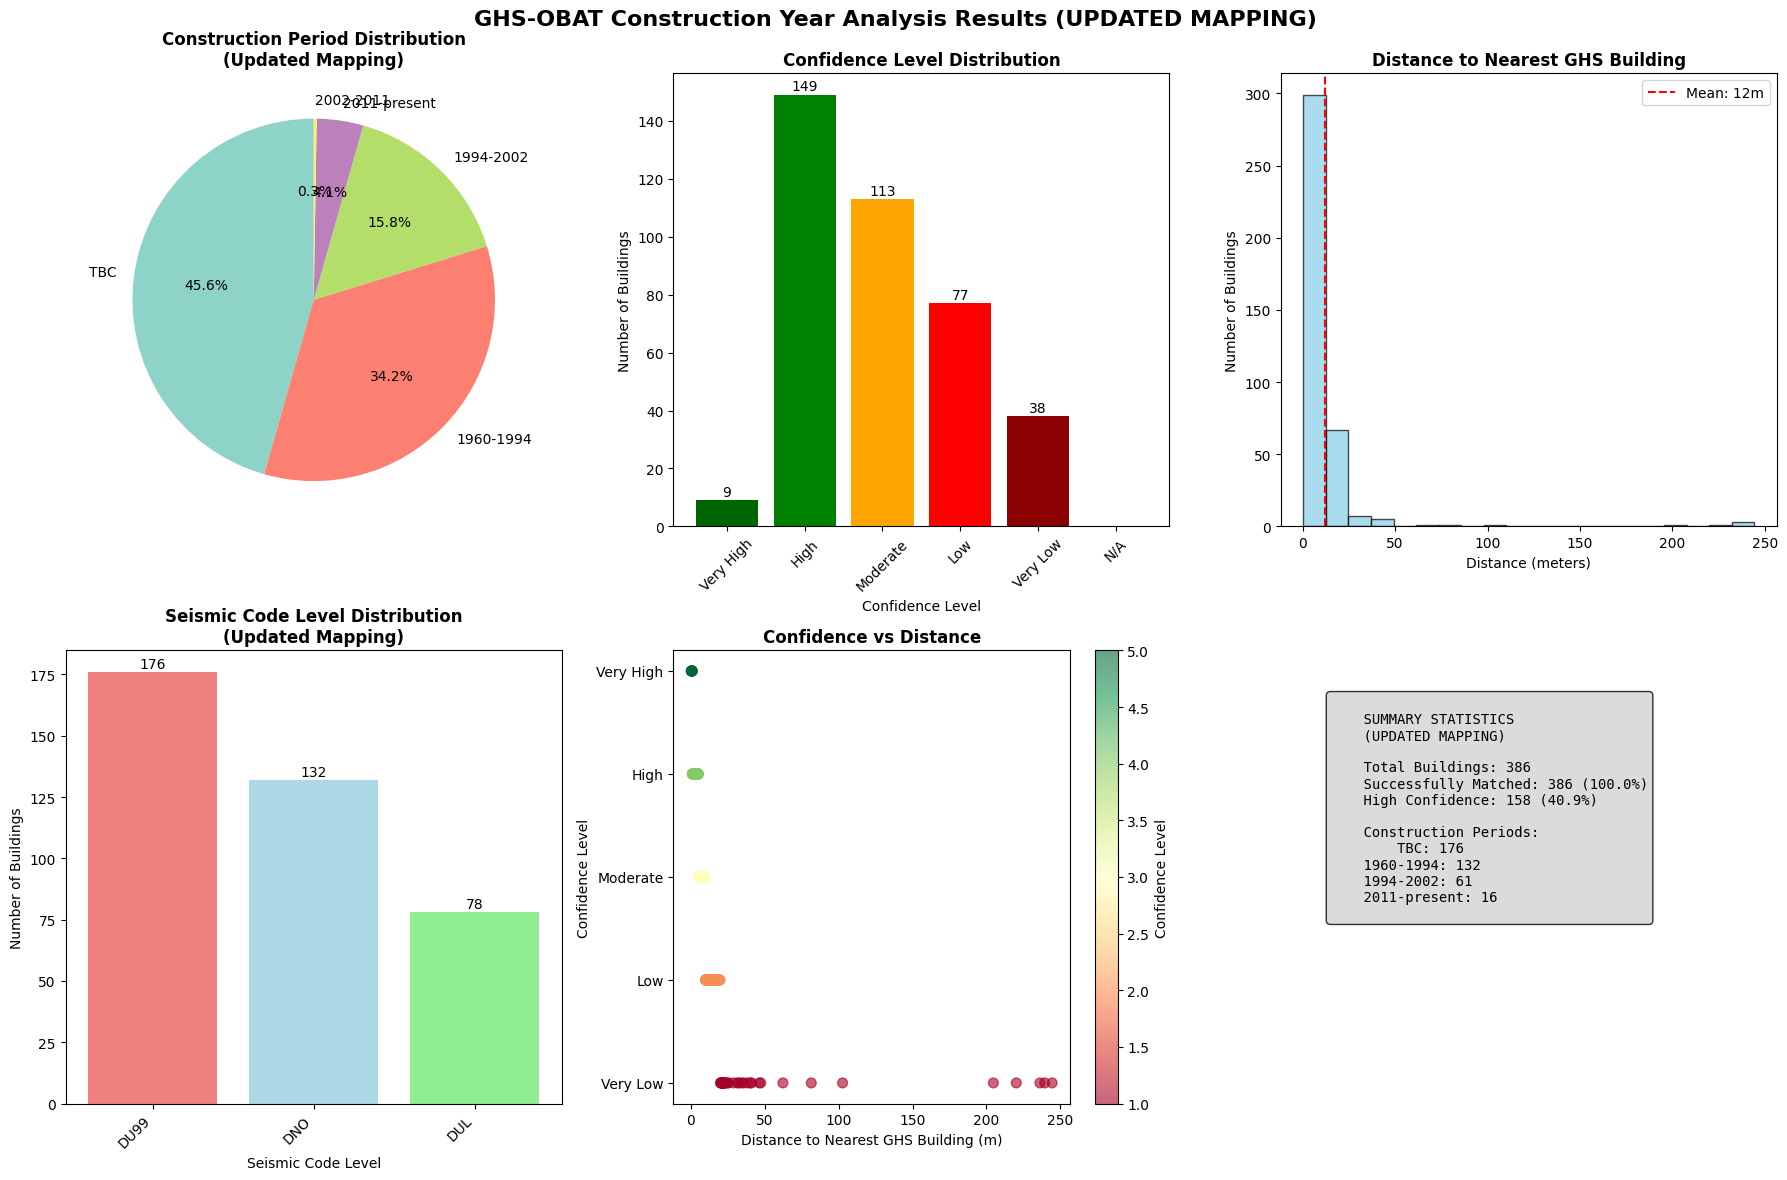

✅ Visualizations created and saved as 'ghs_obat_analysis_results_updated.png'


In [ ]:
def create_analysis_visualizations(results_df):
    """
    Generate comprehensive visualizations of the GHS-OBAT analysis results
    """
    print(f"\n📈 SECTION 6: Creating visualizations...")

    # Set up the plotting style
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('GHS-OBAT Construction Year Analysis Results (UPDATED MAPPING)', fontsize=16, fontweight='bold')

    # 1. Construction Period Distribution (Pie Chart)
    period_counts = results_df['Estimated_Construction_Period'].value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(period_counts)))
    axes[0, 0].pie(period_counts.values, labels=period_counts.index, autopct='%1.1f%%',
                   colors=colors, startangle=90)
    axes[0, 0].set_title('Construction Period Distribution\n(Updated Mapping)', fontweight='bold')

    # 2. Confidence Level Distribution (Bar Chart)
    confidence_counts = results_df['Confidence_Level'].value_counts()
    confidence_order = ['Very High', 'High', 'Moderate', 'Low', 'Very Low', 'N/A']
    confidence_ordered = confidence_counts.reindex(confidence_order, fill_value=0)

    bars = axes[0, 1].bar(range(len(confidence_ordered)), confidence_ordered.values,
                         color=['darkgreen', 'green', 'orange', 'red', 'darkred', 'gray'])
    axes[0, 1].set_title('Confidence Level Distribution', fontweight='bold')
    axes[0, 1].set_xlabel('Confidence Level')
    axes[0, 1].set_ylabel('Number of Buildings')
    axes[0, 1].set_xticks(range(len(confidence_ordered)))
    axes[0, 1].set_xticklabels(confidence_ordered.index, rotation=45)

    # Add value labels on bars
    for bar, value in zip(bars, confidence_ordered.values):
        if value > 0:
            axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                           str(value), ha='center', va='bottom')

    # 3. Distance Distribution (Histogram)
    successful_matches = results_df[results_df['Status'] == 'Matched']
    if len(successful_matches) > 0:
        axes[0, 2].hist(successful_matches['Nearest_Distance_m'], bins=20,
                       color='skyblue', edgecolor='black', alpha=0.7)
        axes[0, 2].set_title('Distance to Nearest GHS Building', fontweight='bold')
        axes[0, 2].set_xlabel('Distance (meters)')
        axes[0, 2].set_ylabel('Number of Buildings')
        axes[0, 2].axvline(successful_matches['Nearest_Distance_m'].mean(),
                          color='red', linestyle='--', label=f'Mean: {successful_matches["Nearest_Distance_m"].mean():.0f}m')
        axes[0, 2].legend()
    else:
        axes[0, 2].text(0.5, 0.5, 'No successful matches\nfor distance analysis',
                       ha='center', va='center', transform=axes[0, 2].transAxes)
        axes[0, 2].set_title('Distance Distribution - No Data')

    # 4. Seismic Code Level Distribution (Bar Chart)
    code_counts = results_df['Seismic_Code_Level'].value_counts()
    bars = axes[1, 0].bar(range(len(code_counts)), code_counts.values,
                         color=['lightcoral', 'lightblue', 'lightgreen', 'gray'])
    axes[1, 0].set_title('Seismic Code Level Distribution\n(Updated Mapping)', fontweight='bold')
    axes[1, 0].set_xlabel('Seismic Code Level')
    axes[1, 0].set_ylabel('Number of Buildings')
    axes[1, 0].set_xticks(range(len(code_counts)))
    axes[1, 0].set_xticklabels(code_counts.index, rotation=45, ha='right')

    # Add value labels
    for bar, value in zip(bars, code_counts.values):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                       str(value), ha='center', va='bottom')

    # 5. Confidence vs Distance Scatter Plot
    if len(successful_matches) > 0:
        confidence_mapping = {'Very High': 5, 'High': 4, 'Moderate': 3, 'Low': 2, 'Very Low': 1}
        successful_matches_copy = successful_matches.copy()
        successful_matches_copy['Confidence_Numeric'] = successful_matches_copy['Confidence_Level'].map(confidence_mapping)

        scatter = axes[1, 1].scatter(successful_matches_copy['Nearest_Distance_m'],
                                   successful_matches_copy['Confidence_Numeric'],
                                   alpha=0.6, s=50, c=successful_matches_copy['Confidence_Numeric'],
                                   cmap='RdYlGn')
        axes[1, 1].set_title('Confidence vs Distance', fontweight='bold')
        axes[1, 1].set_xlabel('Distance to Nearest GHS Building (m)')
        axes[1, 1].set_ylabel('Confidence Level')
        axes[1, 1].set_yticks([1, 2, 3, 4, 5])
        axes[1, 1].set_yticklabels(['Very Low', 'Low', 'Moderate', 'High', 'Very High'])
        plt.colorbar(scatter, ax=axes[1, 1], label='Confidence Level')
    else:
        axes[1, 1].text(0.5, 0.5, 'No data available\nfor confidence analysis',
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Confidence vs Distance - No Data')

    # 6. Summary Statistics Table
    axes[1, 2].axis('off')

    # Create summary statistics
    total = len(results_df)
    matched = len(results_df[results_df['Status'] == 'Matched'])
    high_confidence = len(results_df[results_df['Confidence_Level'].isin(['Very High', 'High'])])

    summary_text = f"""
    SUMMARY STATISTICS
    (UPDATED MAPPING)

    Total Buildings: {total}
    Successfully Matched: {matched} ({matched/total*100:.1f}%)
    High Confidence: {high_confidence} ({high_confidence/total*100:.1f}%)

    Construction Periods:
    """

    for period, count in results_df['Estimated_Construction_Period'].value_counts().head(4).items():
        summary_text += f"    {period}: {count}\n"

    axes[1, 2].text(0.1, 0.9, summary_text, transform=axes[1, 2].transAxes,
                   fontsize=10, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    plt.tight_layout()
    plt.savefig('ghs_obat_analysis_results_updated.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Visualizations created and saved as 'ghs_obat_analysis_results_updated.png'")

# Generate visualizations
create_analysis_visualizations(results_df)

# SECTION 7: DATA EXPORT AND INTEGRATION

Export results to new CSV files and create an updated exposure database with
construction year estimates while preserving the original input files.

In [ ]:
def export_results_and_create_updated_database(exposure_data, results_df):
    """
    Export analysis results and create updated exposure database with construction estimates
    UPDATED: Now includes Material+LLRS based ductility classification
    """
    print(f"\n💾 SECTION 7: Data Export and Integration with Material+LLRS Ductility")
    print("=" * 60)

    # 1. Export detailed analysis results
    detailed_results_file = '/content/drive/MyDrive/IRDR0012_Research Project/01 OUTPUT/ghs_obat_detailed_analysis_results_updated.csv'
    results_df.to_csv(detailed_results_file, index=False)
    print(f"✅ Detailed analysis results exported to: {detailed_results_file}")

    # 2. Create updated exposure database with Material+LLRS ductility classification
    print(f"🔄 Creating updated exposure database with ductility classification...")

    # Merge results with original exposure data - handle missing GHS_Height_m column
    available_columns = ['Building_ID', 'Estimated_Construction_Period', 'Seismic_Code_Level',
                        'Confidence_Level', 'Nearest_Distance_m']

    # Only include GHS_Height_m if it exists in results_df
    if 'GHS_Height_m' in results_df.columns:
        available_columns.append('GHS_Height_m')
        print(f"✅ GHS height data available for merging")
    else:
        print(f"⚠️ GHS height data not available - will skip height estimation")

    updated_exposure = exposure_data.merge(
        results_df[available_columns],
        left_on='Description',
        right_on='Building_ID',
        how='left'
    )

    # Add GHS_Height_m column if it doesn't exist
    if 'GHS_Height_m' not in updated_exposure.columns:
        updated_exposure['GHS_Height_m'] = np.nan

    # Apply Material+LLRS based ductility classification to ALL buildings
    print(f"🏗️ Applying Material+LLRS based ductility classification...")

    def classify_building_ductility(row):
        """Apply ductility classification using Material LLRS and LLRS"""
        material_llrs = row.get('Material LLRS', '')
        llrs = row.get('LLRS', '')
        construction_period = row.get('Estimated_Construction_Period', 'Unknown')

        # Use the updated function that prioritizes Material+LLRS
        return assign_seismic_code_level(construction_period, material_llrs, llrs)

    # Apply ductility classification to all buildings
    updated_exposure['Material_LLRS_Ductility'] = updated_exposure.apply(classify_building_ductility, axis=1)

    # NEW: Apply GHS height estimation for missing height data with high confidence
    print(f"🏗️ Applying GHS height estimation for missing height data...")

    def estimate_building_height(row):
        """Estimate building height using GHS data when appropriate"""
        exposure_height = row.get('Height', np.nan)
        confidence_level = row.get('Confidence_Level', 'N/A')
        ghs_height_m = row.get('GHS_Height_m', np.nan)

        # Check if we should update height
        if should_update_height(exposure_height, confidence_level):
            estimated_storeys = estimate_height_from_ghs(ghs_height_m, typical_storey_height_m=3.0)
            return estimated_storeys
        else:
            return exposure_height

    # Store original height data
    updated_exposure['Original_Height'] = updated_exposure['Height'].copy()

    # Apply height estimation
    updated_exposure['Height'] = updated_exposure.apply(estimate_building_height, axis=1)

    # Add height source tracking
    def determine_height_source(row):
        """Track source of height data"""
        original_height = row.get('Original_Height', np.nan)
        confidence_level = row.get('Confidence_Level', 'N/A')
        ghs_height_m = row.get('GHS_Height_m', np.nan)

        # Check if original height was missing/unknown with proper type handling
        original_missing = False

        if pd.isna(original_height):
            original_missing = True
        elif original_height == '':
            original_missing = True
        elif str(original_height).lower() in ['unknown', 'unknow', 'nan', 'null']:
            original_missing = True
        else:
            try:
                height_numeric = float(original_height)
                if height_numeric <= 0:
                    original_missing = True
            except (ValueError, TypeError):
                original_missing = True

        if not original_missing:
            return 'Original_Data'
        elif confidence_level in ['Very High', 'High'] and pd.notna(ghs_height_m):
            return 'GHS_Estimated_High_Confidence'
        else:
            return 'Missing_No_GHS_Data'

    updated_exposure['Height_Source'] = updated_exposure.apply(determine_height_source, axis=1)

    # Create a comprehensive ductility column that prioritizes Material+LLRS over GHS estimates
    updated_exposure['Final_Ductility_Level'] = updated_exposure['Material_LLRS_Ductility']

    # Add ductility source tracking
    def determine_ductility_source(row):
        material_llrs = row.get('Material LLRS', '')
        llrs = row.get('LLRS', '')
        if pd.notna(material_llrs) and material_llrs != '' and pd.notna(llrs) and llrs != '':
            return 'Material_LLRS_Based'
        elif row.get('Estimated_Construction_Period', 'Unknown') != 'Unknown':
            return 'GHS_Construction_Period_Based'
        else:
            return 'Default_Unknown'

    updated_exposure['Ductility_Classification_Source'] = updated_exposure.apply(determine_ductility_source, axis=1)

    # Update the construction date column with estimates (only where missing)
    updated_exposure['Original_Construction_Date'] = updated_exposure['Date of construction or retrofit'].copy()

    # Fill missing construction dates with GHS estimates
    mask_missing = (updated_exposure['Date of construction or retrofit'].isna() |
                   (updated_exposure['Date of construction or retrofit'] == ''))

    updated_exposure.loc[mask_missing, 'Date of construction or retrofit'] = \
        updated_exposure.loc[mask_missing, 'Estimated_Construction_Period']

    # Add data source tracking for construction dates
    updated_exposure['Construction_Date_Source'] = updated_exposure.apply(
        lambda row: 'Original_Data' if pd.notna(row['Original_Construction_Date']) and row['Original_Construction_Date'] != ''
        else 'GHS_Estimated' if row['Estimated_Construction_Period'] != 'Unknown'
        else 'Not_Available', axis=1
    )

    # Clean up temporary columns
    updated_exposure = updated_exposure.drop(columns=['Building_ID'], errors='ignore')

    # 3. Export updated exposure database
    updated_exposure_file = 'updated_exposure_database_with_material_llrs_ductility.csv'
    updated_exposure.to_csv(updated_exposure_file, index=False)
    print(f"✅ Updated exposure database exported to: {updated_exposure_file}")

    # 4. Create comprehensive ductility analysis report
    print(f"\n📊 Ductility Classification Analysis:")

    # Overall ductility distribution
    ductility_counts = updated_exposure['Final_Ductility_Level'].value_counts()
    print(f"\n🏗️ Overall Ductility Distribution (All {len(updated_exposure)} Buildings):")
    for ductility, count in ductility_counts.items():
        percentage = (count / len(updated_exposure)) * 100
        print(f"   {ductility}: {count} ({percentage:.1f}%)")

    # Ductility source breakdown
    source_counts = updated_exposure['Ductility_Classification_Source'].value_counts()
    print(f"\n📋 Ductility Classification Source:")
    for source, count in source_counts.items():
        percentage = (count / len(updated_exposure)) * 100
        print(f"   {source}: {count} ({percentage:.1f}%)")

    # Material+LLRS specific analysis
    material_llrs_buildings = updated_exposure[
        updated_exposure['Ductility_Classification_Source'] == 'Material_LLRS_Based'
    ]

    if len(material_llrs_buildings) > 0:
        print(f"\n🎯 Material+LLRS Based Classification Details ({len(material_llrs_buildings)} buildings):")

        # Group by Material LLRS + LLRS combination
        material_combinations = {}
        for _, row in material_llrs_buildings.iterrows():
            combo = f"{row.get('Material LLRS', '')} + {row.get('LLRS', '')}"
            ductility = row['Final_Ductility_Level']
            if combo not in material_combinations:
                material_combinations[combo] = {}
            material_combinations[combo][ductility] = material_combinations[combo].get(ductility, 0) + 1

        # Sort by frequency
        for combo in sorted(material_combinations.keys(),
                           key=lambda x: sum(material_combinations[x].values()), reverse=True):
            total = sum(material_combinations[combo].values())
            ductility_dist = material_combinations[combo]
            main_ductility = max(ductility_dist.keys(), key=lambda x: ductility_dist[x])
            print(f"   {combo}: {total} buildings → {main_ductility}")

    # Construction period improvement analysis
    original_missing = exposure_data['Date of construction or retrofit'].isna().sum()
    final_missing = (updated_exposure['Date of construction or retrofit'].isna() |
                    (updated_exposure['Date of construction or retrofit'] == 'Unknown')).sum()

    print(f"\n📈 Construction Date Improvement Summary:")
    print(f"   Original buildings missing construction dates: {original_missing}")
    print(f"   Final buildings missing construction dates: {final_missing}")
    print(f"   Buildings improved with GHS estimates: {original_missing - final_missing}")
    if original_missing > 0:
        print(f"   Improvement rate: {((original_missing - final_missing) / original_missing * 100):.1f}%")

    # NEW: Height estimation improvement analysis
    def is_height_missing(height_val):
        """Helper function to check if height is missing with proper type handling"""
        if pd.isna(height_val):
            return True
        elif height_val == '':
            return True
        elif str(height_val).lower() in ['unknown', 'unknow', 'nan', 'null']:
            return True
        else:
            try:
                height_numeric = float(height_val)
                return height_numeric <= 0
            except (ValueError, TypeError):
                return True

    original_height_missing = exposure_data['Height'].apply(is_height_missing).sum()
    ghs_height_estimated = (updated_exposure['Height_Source'] == 'GHS_Estimated_High_Confidence').sum()
    final_height_missing = updated_exposure['Height'].apply(is_height_missing).sum()

    print(f"\n🏗️ Height Data Improvement Summary:")
    print(f"   Original buildings missing height data: {original_height_missing}")
    print(f"   Buildings improved with GHS height estimates: {ghs_height_estimated}")
    print(f"   Final buildings missing height data: {final_height_missing}")
    if original_height_missing > 0:
        improvement_rate = ((original_height_missing - final_height_missing) / original_height_missing * 100)
        print(f"   Height improvement rate: {improvement_rate:.1f}%")

    # Height source breakdown
    height_source_counts = updated_exposure['Height_Source'].value_counts()
    print(f"\n📊 Height Data Source Breakdown:")
    for source, count in height_source_counts.items():
        percentage = (count / len(updated_exposure)) * 100
        print(f"   {source}: {count} ({percentage:.1f}%)")

    # Show GHS height estimation statistics for successful cases
    ghs_estimated_heights = updated_exposure[
        updated_exposure['Height_Source'] == 'GHS_Estimated_High_Confidence'
    ]

    if len(ghs_estimated_heights) > 0:
        print(f"\n🎯 GHS Height Estimation Details:")
        print(f"   Buildings with GHS height estimates: {len(ghs_estimated_heights)}")
        print(f"   Mean estimated height: {ghs_estimated_heights['Height'].mean():.1f} storeys")
        print(f"   Height range: {ghs_estimated_heights['Height'].min():.0f} to {ghs_estimated_heights['Height'].max():.0f} storeys")

        # Show confidence level breakdown for height estimates
        confidence_breakdown = ghs_estimated_heights['Confidence_Level'].value_counts()
        print(f"   Confidence level breakdown:")
        for confidence, count in confidence_breakdown.items():
            print(f"     {confidence}: {count} buildings")

    # 5. Export ductility and height classification summary
    ductility_summary = {
        'Total_Buildings': len(updated_exposure),
        'Material_LLRS_Based_Classification': len(material_llrs_buildings),
        'DUC_Ductile': ductility_counts.get('DUC', 0),
        'DUL_Limited_Ductility': ductility_counts.get('DUL', 0),
        'DNO_Non_Ductile': ductility_counts.get('DNO', 0),
        'DU99_Unknown_Ductility': ductility_counts.get('DU99', 0),
        'GHS_Construction_Period_Based': source_counts.get('GHS_Construction_Period_Based', 0),
        'Material_LLRS_Coverage_Percent': (len(material_llrs_buildings) / len(updated_exposure) * 100) if len(updated_exposure) > 0 else 0,
        'Original_Height_Missing': original_height_missing,
        'GHS_Height_Estimated': ghs_height_estimated,
        'Height_Improvement_Count': original_height_missing - final_height_missing,
        'Height_Improvement_Rate_Percent': ((original_height_missing - final_height_missing) / original_height_missing * 100) if original_height_missing > 0 else 0
    }

    summary_df = pd.DataFrame([ductility_summary])
    summary_file = 'ductility_and_height_classification_summary.csv'
    summary_df.to_csv(summary_file, index=False)
    print(f"✅ Enhanced classification summary exported to: {summary_file}")

    return updated_exposure

# Export results and create updated database
final_exposure_database = export_results_and_create_updated_database(exposure_data, results_df)



💾 SECTION 7: Data Export and Integration with Material+LLRS Ductility
✅ Detailed analysis results exported to: /content/drive/MyDrive/IRDR0012_Research Project/01 OUTPUT/ghs_obat_detailed_analysis_results_updated.csv
🔄 Creating updated exposure database with ductility classification...
✅ GHS height data available for merging
🏗️ Applying Material+LLRS based ductility classification...
🏗️ Applying GHS height estimation for missing height data...
✅ Updated exposure database exported to: updated_exposure_database_with_material_llrs_ductility.csv

📊 Ductility Classification Analysis:

🏗️ Overall Ductility Distribution (All 386 Buildings):
   DUL: 243 (63.0%)
   DNO: 77 (19.9%)
   DUC: 35 (9.1%)
   DU99: 31 (8.0%)

📋 Ductility Classification Source:
   Material_LLRS_Based: 383 (99.2%)
   GHS_Construction_Period_Based: 3 (0.8%)

🎯 Material+LLRS Based Classification Details (383 buildings):
   MCF+CLBRH+MO99 + LWAL: 92 buildings → DUL
   MCF+CB99+MO99 + LWAL: 90 buildings → DUL
   EU+ETR + LW